In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re

In [3]:
ratings = pd.read_csv(
    "../MIND/behaviors.tsv",
    sep='\t',
    header=None,
    names=["impressionId", "userId", "time", "history", "impressions"]
  )

ratings = ratings.dropna()

def aggregateRating(x): 
  items = x.split(" ")
  clicked = re.findall(r"\w+-1", x)
  return len(items) // len(clicked)

def getClicked(x):
  return re.findall(r"(\w+)-1", x)

printed = False
def aggregateImpression(x):
  clicked = re.findall(r"(\w+)-1", x)
  size = len(x.split(" "))
  print(clicked, size)

ratings["rating"] = ratings["impressions"].apply(aggregateRating)
ratings["newsId"] = ratings["impressions"].apply(getClicked)
ratings = ratings.explode("newsId", ignore_index=True)

ratings["ratingId"] = ratings["impressionId"].astype(str) + "-" + ratings["newsId"]

ratings = ratings[["ratingId", "impressionId", "userId", "newsId", "rating"]]

In [4]:
print(ratings.info())
print(ratings["ratingId"].nunique())

print(ratings.head())
print()
print(ratings.tail())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107968 entries, 0 to 107967
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   ratingId      107968 non-null  object
 1   impressionId  107968 non-null  int64 
 2   userId        107968 non-null  object
 3   newsId        107968 non-null  object
 4   rating        107968 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 4.1+ MB
None
107968
   ratingId  impressionId  userId  newsId  rating
0  1-N31958             1  U80234  N31958      22
1  2-N23513             2  U60458  N23513       7
2   3-N5940             3  U44190   N5940      23
3  4-N15347             4  U87380  N15347      26
4   5-N5940             5   U9444   N5940       7

            ratingId  impressionId  userId  newsId  rating
107963  73149-N11390         73149  U56193  N11390      17
107964  73150-N60215         73150  U16799  N60215      37
107965  73150-N54562         73150  U16799  N5456

### Distribution of ratings

Even though these are not real ratings

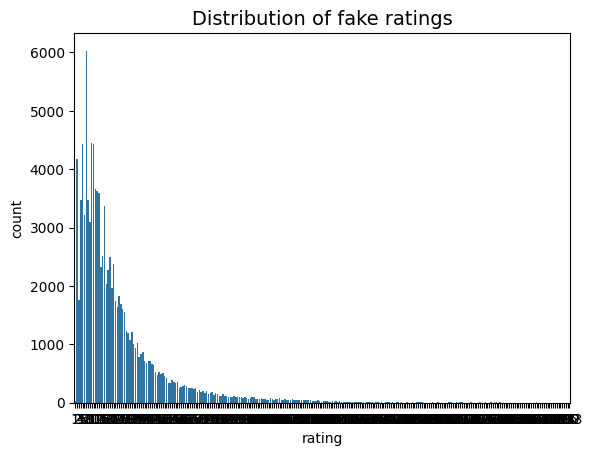

In [5]:
sns.countplot(x="rating", data=ratings)
plt.title("Distribution of fake ratings", fontsize=14)
plt.show()

In [6]:
print(f"Mean rating {round(ratings["rating"].mean(), 2)}")

Mean rating 24.45


In [7]:
news = pd.read_csv(
  "../MIND/news.tsv",
  sep="\t", 
  header=None,
  names=["newsId", "category", "subcategory", "title", "abstract", "url", "titleEntities", "abstractEntities"],
  usecols=["newsId", "title"]
)

print(news.head())
print(news.info())

   newsId                                              title
0  N55528  The Brands Queen Elizabeth, Prince Charles, an...
1  N18955  Dispose of unwanted prescription drugs during ...
2  N61837  The Cost of Trump's Aid Freeze in the Trenches...
3  N53526  I Was An NBA Wife. Here's How It Affected My M...
4  N38324  How to Get Rid of Skin Tags, According to a De...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42416 entries, 0 to 42415
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   newsId  42416 non-null  object
 1   title   42416 non-null  object
dtypes: object(2)
memory usage: 662.9+ KB
None


In [8]:
from scipy.sparse import csr_matrix

def create_X(df): 
  """
  Sparse matrix
  Args:
    df: dataframe with 3 columns (userId, newsId, rating)
  """
  M = df['userId'].nunique()
  N = df['newsId'].nunique()

  user2index = dict(zip(np.unique(df["userId"]), list(range(M))))
  news2index = dict(zip(np.unique(df["newsId"]), list(range(N))))

  index2user = dict(zip(list(range(M)), np.unique(df["userId"])))
  index2news = dict(zip(list(range(N)), np.unique(df["newsId"])))

  user_index = [user2index[i] for i in df["userId"]]
  news_index = [news2index[i] for i in df["newsId"]]

  X = csr_matrix((df["rating"], (user_index, news_index)), shape=(M, N))

  return X, user2index, news2index, index2user, index2news

X, user2index, news2index, index2user, index2news = create_X(ratings)

In [9]:
n_total = X.shape[0] * X.shape[1]
n_ratings = X.nnz
sparsity = n_ratings / n_total

print(f"Matrix sparsity: {round(sparsity*100, 2)}%")

Matrix sparsity: 0.1%


A sparsity of 0.1% is the absolute lowest possible where collaborative filtering makes sense at all. 

In [10]:
clicks_per_user = X.getnnz(axis=1)

print(f"total users {len(clicks_per_user)}")
print(f"Most clicking user {clicks_per_user.max()}")
print(f"Min clicking user {clicks_per_user.min()}")


total users 48593
Most clicking user 30
Min clicking user 1


In [11]:
clicks_per_article = X.getnnz(axis=0)

print(f"Most clicked {clicks_per_article.max()}")
print(f"Min clicked {clicks_per_article.min()}")


Most clicked 7795
Min clicked 1


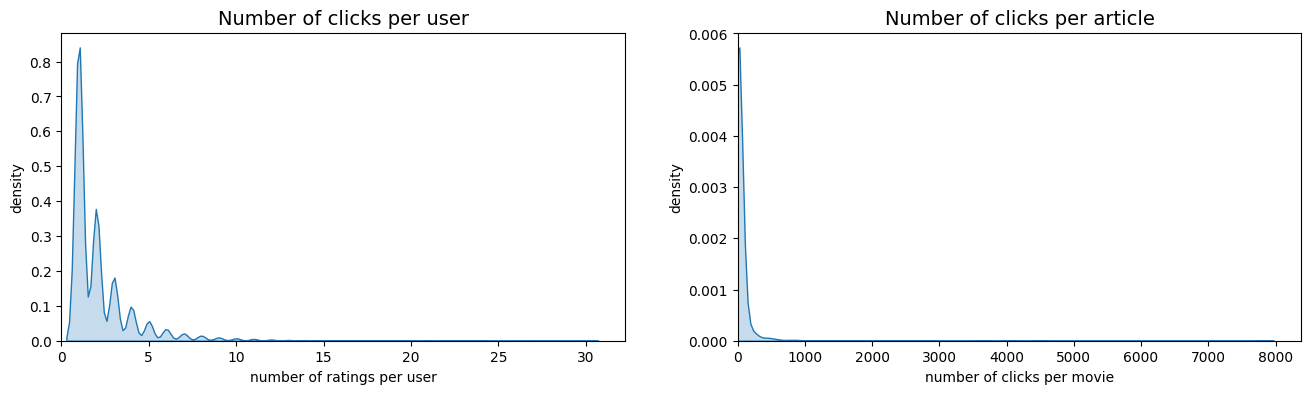

In [12]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
sns.kdeplot(clicks_per_user, fill=True)
plt.xlim(0)
plt.title("Number of clicks per user", fontsize=14)
plt.xlabel("number of ratings per user")
plt.ylabel("density")
plt.subplot(1, 2, 2)
sns.kdeplot(clicks_per_article, fill=True)
plt.xlim(0)
plt.title("Number of clicks per article", fontsize=14)
plt.xlabel("number of clicks per movie")
plt.ylabel("density")
plt.show()


In [21]:
from sklearn.neighbors import NearestNeighbors

def find_similar_news(news_id, X, news2index, index2news, k, metric='cosine'):
  X = X.T
  neighbor_ids = []

  news_idx = news2index[news_id]
  news_vec = X[news_idx]

  if isinstance(news_vec, (np.ndarray)):
    news_vec = news_vec.reshape(1, -1)
  
  kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
  kNN.fit(X)
  neighbor = kNN.kneighbors(news_vec, return_distance=False)
  for i in range(0, k):
    n = neighbor.item(i)
    neighbor_ids.append(index2news[n])
  neighbor_ids.pop(0)
  return neighbor_ids



In [14]:
similar_news = find_similar_news("N31958", X, news2index, index2news, k=10)
similar_news

['N58251',
 'N36779',
 'N23513',
 'N5472',
 'N42844',
 'N30290',
 'N5940',
 'N21484',
 'N19990']

In [18]:
newsId2title = dict(zip(news["newsId"], news["title"]))
print(newsId2title["N31958"])

print()

for i in similar_news:
  print(newsId2title[i])


Opinion: Colin Kaepernick is about to get what he deserves: a chance

Some believe Mason Rudolph, hit in head with his own helmet, isn't getting enough blame
South Carolina teen gets life in prison for deadly elementary school shooting
This was uglier than a brawl. And Myles Garrett deserves suspension for rest of year after helmet attack.
Report: Police investigating woman's death after Redskins' player Montae Nicholson took her to hospital
Survivor Contestants Missy Byrd and Elizabeth Beisel Apologize For Their Actions
The Real Reason McDonald's Keeps the Filet-O-Fish on Their Menu
Meghan Markle and Hillary Clinton Secretly Spent the Afternoon Together at Frogmore Cottage
Hue Jackson will run Colin Kaepernick's passing drills, 11 teams have said they'll attend
Cows swept away by Hurricane Dorian found alive   but how?


#### Dimensionality Reduction (SVD)

In [17]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=20, n_iter=10)
Q = svd.fit_transform(X.T)
Q.shape

(2188, 20)

In [ ]:
news_id = "N31958"
similar_news = find_similar_news(news_id, Q.T, news2index, index2news, metric="cosine", k=10)

print(newsId2title[news_id])
print("\nSimilar news:")

for i in similar_news:
  print(newsId2title[i]) 

# Are they similar? Does not feel like it...


Opinion: Colin Kaepernick is about to get what he deserves: a chance

Similar news:
Earthquake puts a crack in France
State of emergency declared amid flooding
Former intelligence officer reacts to impeachment hearings against Trump
17 Super Clever Ways for Getting Rid of Junk
Trust seeks seizure of Rudy Giuliani associate Lev Parnas's bail to repay $678K judgment
Katie Couric Says Matt Lauer 'Ultimately Turned Out to Be Two Very Different People'
Japan Wants You To Stop Buying All Its Skyline GT-Rs
15 Household Mainstays from Your Childhood That You Won't Find in New Homes
Popular New York high school football coach, teacher reassigned pending investigation
